# Greedy MSU selection

Choose MSU locations based on which improves overall utility most.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from classes.geography_processing import Geoprocessing
from classes.model import Model
from classes.scenario import Scenario

# Turn off all warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Proportion of treated patients that are LVO
prop_lvo = 0.40

# Maximum number of hospitals to select
max_hospitals = 100

## Base case

MSU provided from comprehensive stroke centres (thrombectomy centres)

In [3]:
# Set up scenario
scenario = Scenario({
    'name': 1,
    'limit_to_england' : True
})

# Process and save geographic data (only needed when hospital data changes)
geo = Geoprocessing(limit_to_england=True); geo.run()

# Set up model
model = Model(
    scenario=scenario,
    geodata=pd.read_csv('processed_data/processed_data.csv'))

# Run model
model.run()

# Get utilities
lsoa_drip_ship_utility = (
    (model.full_results['lvo_drip_ship_ivt_mt_utility'] * prop_lvo) + 
    (model.full_results['nlvo_drip_ship_ivt_utility'] * (1 - prop_lvo)))

# Get the weighted average of lsoa_drip_ship_utility 
average_utility_drip_ship = np.sum(
    model.full_results['Admissions'] * lsoa_drip_ship_utility) / np.sum(model.full_results['Admissions'])

lsoa_drip_ship_utility_shift = (
    (model.full_results['lvo_drip_ship_ivt_mt_utility_shift'] * prop_lvo) + 
    (model.full_results['nlvo_drip_ship_ivt_utility_shift'] * (1 - prop_lvo)))

lsoa_msu_utility_shift = (
    (model.full_results['lvo_msu_ivt_mt_utility_shift'] * prop_lvo) + 
    (model.full_results['nlvo_msu_ivt_utility_shift'] * (1 - prop_lvo)))

# Get the maximum of MSU and drip and ship
best_utility_shift = np.maximum(lsoa_msu_utility_shift, lsoa_drip_ship_utility_shift)

# Get the weighted average of lsoa_drip_ship_utility shift 
average_utility_drip_ship_shift = np.sum(
    model.full_results['Admissions'] * lsoa_drip_ship_utility_shift) / np.sum(model.full_results['Admissions'])

# Get the average utility weighted by model.full_results['Admissions']
average_utility_shift = np.sum(model.full_results['Admissions'] * best_utility_shift) / np.sum(model.full_results['Admissions'])

# Get the advantage of MSU over drip and ship
advantage = average_utility_shift - average_utility_drip_ship_shift

In [4]:
untreated_utility = (average_utility_drip_ship - average_utility_drip_ship_shift)
print(f'Average untreated utility: {untreated_utility:0.3f}')
print(f'Average utility improvement for drip and ship: {average_utility_drip_ship_shift:0.3f}')
print(f'Average utility advantage for MSU over drip and ship: {advantage:0.3f}')


Average untreated utility: 0.493
Average utility improvement for drip and ship: 0.096
Average utility advantage for MSU over drip and ship: 0.027


In [5]:
# Set up scenario
scenario = Scenario({
    'name': 1,
})

# Set up geoprocessing module and load initial data (and  set Use_MSU column to zero
geo = Geoprocessing(limit_to_england = True)
geo.load_data()
geo.hospitals['Use_MSU'] = 0

# Travel processing for constant locations
geo.find_nearest_ivt_unit()
geo.find_nearest_mt_unit()
geo.find_nearest_transfer_mt_unit()

# Set up list of selected and unselected MSUs
selected_MSUs = []
used_hospitals_mask = geo.hospitals['Use_IVT'] == 1
unelected_MSUs = list(geo.hospitals[used_hospitals_mask].index)

## Benefit from each hospital as a MSU base


In [6]:
geo.hospitals['Use_MSU'] = 0
hospitals = geo.hospitals.copy(deep=True)
                                   
# Loop through all MSUs
possible_msu_locations = list(geo.hospitals[used_hospitals_mask].index)
advantages = []

for msu in possible_msu_locations:
    data_copy = hospitals.copy(deep=True)
    data_copy.loc[msu, 'Use_MSU'] = 1
    geo.hospitals = data_copy.copy()
    geo.find_nearest_msu_unit()
    geo.collate_data()
    geo.save_processed_data()

    model = Model(
        scenario=scenario,
        geodata=pd.read_csv('processed_data/processed_data.csv')
    )

    model.run()

    # Get utilitites
    lsoa_msu_utility_shift = (
        (model.full_results['lvo_msu_ivt_mt_utility_shift'] * prop_lvo) + 
        (model.full_results['nlvo_msu_ivt_utility_shift'] * (1 - prop_lvo)))

    lsoa_drip_ship_utility_shift = (
        (model.full_results['lvo_drip_ship_ivt_mt_utility_shift'] * prop_lvo) + 
        (model.full_results['nlvo_drip_ship_ivt_utility_shift'] * (1 - prop_lvo)))

    # Get the maximum of MSU and drip and ship
    best_utility_shift = np.maximum(lsoa_msu_utility_shift, lsoa_drip_ship_utility_shift)

    # Get the weighted average of lsoa_drip_ship_utility
    average_utility_drip_ship_shift = np.sum(
        model.full_results['Admissions'] * lsoa_drip_ship_utility_shift) / np.sum(model.full_results['Admissions'])

    # Get the average utility weighted by model.full_results['Admissions']
    average_utility_shift = np.sum(model.full_results['Admissions'] * best_utility_shift) / np.sum(model.full_results['Admissions'])

    # Get the advantage of MSU over drip and ship
    advantage = average_utility_shift - average_utility_drip_ship_shift

    advantages.append(advantage)


results = geo.hospitals.copy(deep=True)
results = results[used_hospitals_mask]
results['MSU advantage'] = advantages

results.to_csv('output/msu_advantages_individual.csv')

## Greedy selection of MSUs

In [7]:
hospitals = geo.hospitals.copy(deep=True)
best_advantage = 0
advantages = []

# Loop through greedy selection process
while (len(unelected_MSUs) > 0) & (len(selected_MSUs) < max_hospitals):

    # Loop through all MSUs
    for msu in unelected_MSUs:
        data_copy = hospitals.copy(deep=True)
        data_copy.loc[msu, 'Use_MSU'] = 1
        geo.hospitals = data_copy.copy()
        geo.find_nearest_msu_unit()
        geo.collate_data()
        geo.save_processed_data()

        model = Model(
            scenario=scenario,
            geodata=pd.read_csv('processed_data/processed_data.csv')
        )

        model.run()
        
            # Get utilitites
        lsoa_msu_utility_shift = (
            (model.full_results['lvo_msu_ivt_mt_utility_shift'] * prop_lvo) + 
            (model.full_results['nlvo_msu_ivt_utility_shift'] * (1 - prop_lvo)))

        lsoa_drip_ship_utility_shift = (
            (model.full_results['lvo_drip_ship_ivt_mt_utility_shift'] * prop_lvo) + 
            (model.full_results['nlvo_drip_ship_ivt_utility_shift'] * (1 - prop_lvo)))

        # Get the maximum of MSU and drip and ship
        best_utility_shift = np.maximum(lsoa_msu_utility_shift, lsoa_drip_ship_utility_shift)

        # Get the weighted average of lsoa_drip_ship_utility
        average_utility_drip_ship_shift = np.sum(
            model.full_results['Admissions'] * lsoa_drip_ship_utility_shift) / np.sum(model.full_results['Admissions'])

        # Get the average utility weighted by model.full_results['Admissions']
        average_utility_shift = np.sum(model.full_results['Admissions'] * best_utility_shift) / np.sum(model.full_results['Admissions'])

        # Get the advantage of MSU over drip and ship
        advantage = average_utility_shift - average_utility_drip_ship_shift
        
        if advantage > best_advantage:
            best_advantage = advantage
            best_MSU = msu

    # Add the best MSU to the selected list
    selected_MSUs.append(best_MSU)
    unelected_MSUs.remove(best_MSU)
    hospitals.loc[best_MSU, 'Use_MSU'] = 1
    advantages.append(best_advantage)

    # print the best MSU and utility
    print(f'{best_MSU}, {best_advantage:0.3f}')

E11BB, 0.008
M68HD, 0.013
B714HJ, 0.016
DN25LT, 0.018
DH15TW, 0.020
TA15DA, 0.021
NR47UY, 0.022
KT160PZ, 0.023
LE15WW, 0.023
DA28DA, 0.024
BS105NB, 0.025
LS13EX, 0.025
LU40DZ, 0.026
PL68DH, 0.026
BN112DH, 0.026
CO45JL, 0.027
NG72UH, 0.027
L97AL, 0.028
PR29HT, 0.028
PE39GZ, 0.028
HU32JZ, 0.028
ST46QG, 0.029
GL13NN, 0.029
CA27HY, 0.029
TR13LQ, 0.029
BH77DW, 0.030
CT13NG, 0.030
NE14LP, 0.030
TS43BW, 0.030
HA13UJ, 0.030
OX39DU, 0.030
S102JF, 0.031
TQ27AA, 0.031
BN212UD, 0.031
CB20QQ, 0.031
SS165NL, 0.031
TF16TF, 0.031
PO305TG, 0.031
LN25QY, 0.031
NN15BD, 0.032
PO63LY, 0.032
SW170QT, 0.032
CV22DX, 0.032
BA214AT, 0.032
RG15AN, 0.032
EX314JB, 0.032
YO318HE, 0.032
SN36BB, 0.032
SK27JE, 0.032
HR12ER, 0.033
CH495PE, 0.033
DE223NE, 0.033
LA144LF, 0.033
BD96RJ, 0.033
PE304ET, 0.033
NG174JL, 0.033
RM70AG, 0.033
NR316LA, 0.033
SG14AB, 0.033
WR51DD, 0.033
BL97TD, 0.033
BA13NG, 0.033
EX25DW, 0.033
ME169QQ, 0.033
IP45PD, 0.033
RH15RH, 0.034
GU167UJ, 0.034
NW12BU, 0.034
BS234TQ, 0.034
HP112TT, 0.034
BB2

In [8]:
greedy_results = geo.hospitals.loc[selected_MSUs]
greedy_results['MSU advantage'] = advantages
greedy_results.to_csv('output/msu_advantages_greedy.csv', index=False)
greedy_results

,Hospital_name,Use_IVT,Use_MT,Use_MSU,Country,Strategic Clinical Network,Health Board / Trust,Stroke Team,SSNAP name,Admissions 21/22,...,ivt_rate,Easting,Northing,long,lat,Neuroscience,30 England Thrombectomy Example,hospital_city,Notes,MSU advantage
Postcode,,,,,,,,,,,,,,,,,,,,,
E11BB,E11BB,1,1,1,England,London SCN,Barts Health NHS Trust,The Royal London Hospital,Royal London Hospital HASU,861,...,13.4,534829,181798,-0.058133,51.519018,1,1,Royal London,NaN,0.007571
M68HD,M68HD,1,1,1,England,Manchester,Lancashire & S.Cumbria SCN,Salford Royal NHS Foundation Trust,Salford Royal Hospital,1848,...,6.5,378637,399030,-2.323424,53.487545,1,1,Salford,NaN,0.012544
B714HJ,B714HJ,1,0,1,England,West Midlands SCN,Sandwell and West Birmingham Hospitals NHS Trust,"Sandwell District Hospital, West Bromwich",Sandwell District Hospital,741,...,6.7,400919,292165,-1.987884,52.527357,0,0,West Bromwich,NaN,0.016118
DN25LT,DN25LT,1,0,1,England,Yorkshire and The Humber SCN,Doncaster and Bassetlaw Hospitals NHS Foundati...,Doncaster Royal Infirmary,Doncaster Royal Infirmary,694,...,9.5,459143,404157,-1.109226,53.530751,0,0,Doncaster,NaN,0.018068
DH15TW,DH15TW,1,0,1,England,North of England SCN,County Durham and Darlington NHS Foundation Trust,University Hospital of North Durham,University Hospital of North Durham,961,...,9.8,426217,543809,-1.593834,54.788497,0,0,North Durham,NaN,0.019772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WD180HB,WD180HB,1,0,1,England,East of England SCN,West Hertfordshire Hospitals NHS Trust,Watford General Hospital,Watford General Hospital,607,...,13.5,510505,195664,-0.404187,51.648921,0,0,Watford,NaN,0.034557
TS198PE,TS198PE,1,0,1,England,North of England SCN,North Tees and Hartlepool NHS Foundation Trust,University Hospitals of North Tees and Hartlepool,University Hospitals of North Tees and Hartlepool,632,...,19.0,442265,521046,-1.347581,54.582857,0,0,Stockton-on-Tees,NaN,0.034579
SW66SX,SW66SX,1,1,1,England,London SCN,Imperial College Healthcare NHS Trust,"Charing Cross Hospital, London",Charing Cross Hospital HASU,1147,...,9.9,524226,176487,-0.212736,51.473717,1,1,Charing Cross,NaN,0.034601


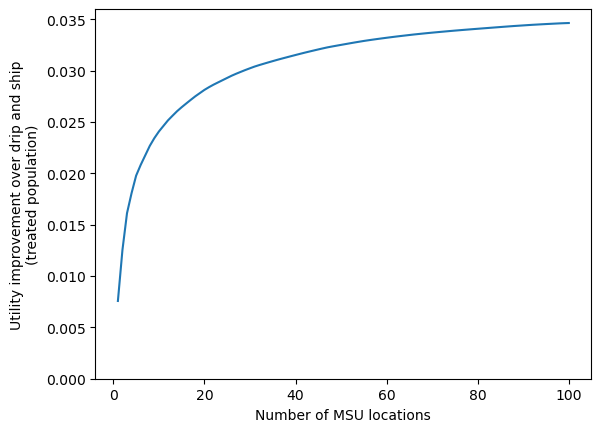

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(len(greedy_results)) + 1
y = greedy_results['MSU advantage']
ax.plot(x, y, '-')
ax.set_xlabel('Number of MSU locations')
ax.set_ylabel('Utility improvement over drip and ship\n(treated population)')
ax.set_ylim(0)

plt.show()
